In [34]:
import cv2
import pandas as ps
from pandas import Series, DataFrame
import numpy as np
import os               
from random import shuffle
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import random
import seaborn as sns
import time
#models
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
#scores
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import glob

In [38]:
warnings.filterwarnings("ignore")

def dfbuilder(files):
    final=pd.DataFrame(columns=['Time_x', 'Experiment_x', ' Hand Type_x', ' # hands_x', ' Position X_x',
       ' Position Y_x', ' Position Z_x', ' Velocity X_x', ' Velocity Y_x',
       ' Velocity Z_x', ' Pitch_x', ' Roll_x', ' Yaw_x', ' Wrist Pos X_x',
       ' Wrist Pos Y_x', ' Wrist Pos Z_x', ' Elbow pos X_x', ' Elbow Pos Y_x',
       ' Elbow Pos Z_x', ' Grab Strenth_x', ' Grab Angle_x',' Pinch Strength_x', 
       'Time_y', 'Experiment_y',
       ' Hand Type_y', ' # hands_y', ' Position X_y', ' Position Y_y',
       ' Position Z_y', ' Velocity X_y', ' Velocity Y_y', ' Velocity Z_y',
       ' Pitch_y', ' Roll_y', ' Yaw_y', ' Wrist Pos X_y', ' Wrist Pos Y_y',
       ' Wrist Pos Z_y', ' Elbow pos X_y', ' Elbow Pos Y_y', ' Elbow Pos Z_y',
       ' Grab Strenth_y', ' Grab Angle_y', ' Pinch Strength_y'])
    for file in files:
        temp=pd.read_csv(file)
        #temp=temp.ix[700:]
        temp[" Hand Type"]=Series([1 if i=="right" else 2 for i in temp[" Hand Type"]])
        if str.__contains__(file,"Alone"):  
            temp.insert(loc=1, column='Experiment', value="1")
            temp=temp.drop(' Frame ID',axis=1)
            Handright=pd.read_csv('HandRight.csv')
            Handright[" Hand Type"]=Series([1 if i=="right" else 2 for i in Handright[" Hand Type"]])
            Handright.insert(loc=1, column='Experiment', value="1")
            Handright = Handright.iloc[:len(temp)-1]
            Handright = Handright.reset_index(drop=True)
            Handright=Handright.drop(' Frame ID',axis=1)
            temp = temp.reset_index(drop=True)
            temp = pd.merge(temp, Handright, left_index=True, right_index=True)
        else:
            if str.__contains__(file,"Sync"):
                temp.insert(loc=1, column='Experiment', value="2")
            if str.__contains__(file,"Spontan"):
                temp.insert(loc=1, column='Experiment', value="3") 
            dfright=temp[temp[" Hand Type"]==1]
            dfleft=temp[temp[" Hand Type"]==2]
            dfright.set_index(' Frame ID',inplace=True)
            dfleft.set_index(' Frame ID',inplace=True)
            temp=pd.merge(dfleft, dfright, how='left',on=' Frame ID') 
        final=pd.concat([final,temp])
        
    final=final.drop(["Experiment_y"],axis=1) 
    final=final.dropna()
    final[final.index%20==2]
    final.sort_index(inplace=True)
    return final

In [39]:
test= dfbuilder(glob.glob('Validation/**/*.csv', recursive=True))
train= dfbuilder(glob.glob('Training/**/*.csv', recursive=True))
#train=train.sort_values(by=['Frame ID_x'])
train.head()

,Time_x,Experiment_x,Hand Type_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,518.8087,1,2,1,-97.60160,164.1213,42.812550,104.258900,-491.673000,-55.42755,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,580.1392,1,2,1,-108.30850,195.5176,113.371800,-3.592897,5.759355,-23.66474,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,561.4594,1,2,1,-70.33230,169.6624,66.570470,116.827600,230.104400,-232.00200,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,288.7583,1,2,1,-10.24803,201.7516,2.468743,17.634300,473.684900,82.42932,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,496.0675,1,2,1,-54.31166,157.7245,15.860700,74.312630,-212.559300,-3.44393,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0


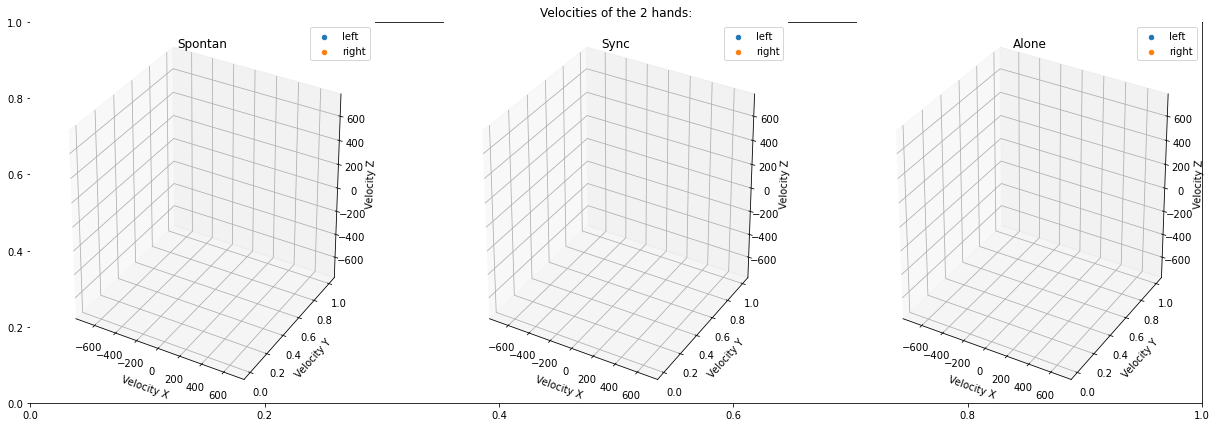

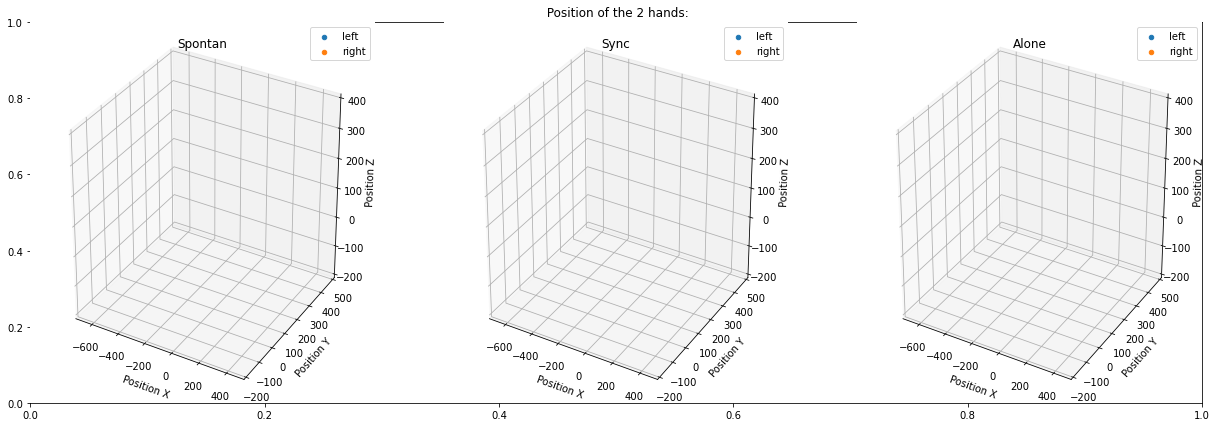

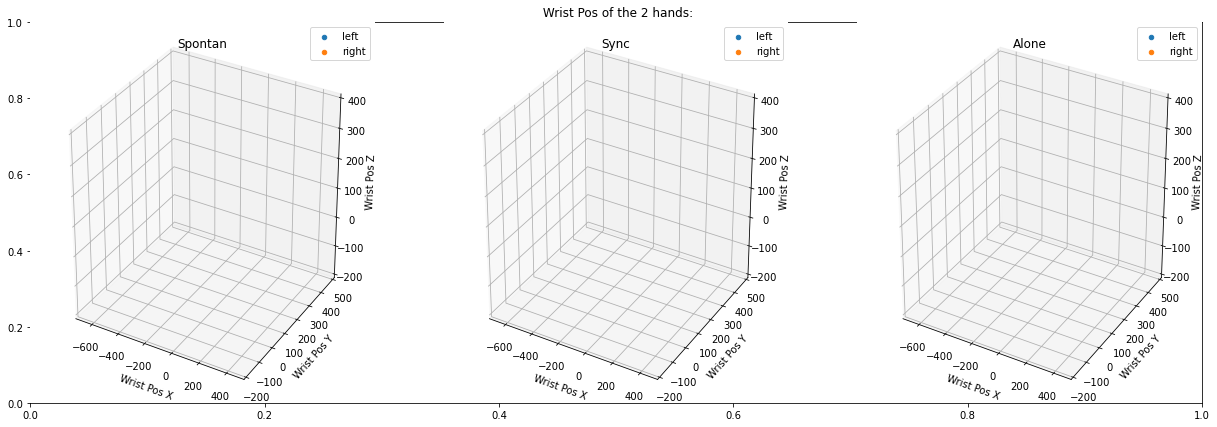

In [41]:
fig = plt.figure(figsize=(21,7))  
plt.title("Velocities of the 2 hands:")
states=['Spontan','Sync','Alone']
velocities=[' Velocity X_x',' Velocity Y_x',' Velocity Z_x',' Velocity X_y',' Velocity Y_y',' Velocity Z_y']
i=1
for state in states:
    ax = fig.add_subplot(1,3,i, projection='3d')
    xl=train[train['Experiment_x']==state][velocities[0]]
    yl=train[train['Experiment_x']==state][velocities[1]]
    zl=train[train['Experiment_x']==state][velocities[2]]
    xr=train[train['Experiment_x']==state][velocities[3]]
    yr=train[train['Experiment_x']==state][velocities[4]]
    zr=train[train['Experiment_x']==state][velocities[5]]
    ax.scatter(xl,yl,zl)
    ax.scatter(xr,yr,zr)
    ax.set_title(state)
    ax.set_xlim([-750,750])
    ax.set_zlim([-750,750])
    ax.set_xlabel("Velocity X")
    ax.set_ylabel("Velocity Y")
    ax.set_zlabel("Velocity Z")
    plt.legend(['left','right'])
    i=i+1

for i in range(1,3):
    if(i==1):
        n=' Position'
    if(i==2):
        n=' Wrist Pos'
    fig = plt.figure(figsize=(21,7))  
    plt.title(n+" of the 2 hands:")    
    Pos=[n+' X_x',n+' Y_x',n+' Z_x',n+' X_y',n+' Y_y',n+' Z_y']
    j=1
    for state in states:
        ax = fig.add_subplot(1,3,j, projection='3d')
        xl=train[train['Experiment_x']==state][Pos[0]]
        yl=train[train['Experiment_x']==state][Pos[1]]
        zl=train[train['Experiment_x']==state][Pos[2]]
        xr=train[train['Experiment_x']==state][Pos[3]]
        yr=train[train['Experiment_x']==state][Pos[4]]
        zr=train[train['Experiment_x']==state][Pos[5]]
        ax.scatter(xl,yl,zl)
        ax.scatter(xr,yr,zr)
        ax.set_title(state)
        ax.set_xlim([-700,500])
        ax.set_ylim([-200,500])
        ax.set_zlim([-200,400])
        ax.set_xlabel(n+' X')
        ax.set_ylabel(n+' Y')
        ax.set_zlabel(n+' Z')
        plt.legend(['left','right'])
        j=j+1